# Selecting TCs for model validation

One way to validate the TCRM wind fields is to look at how well it simulates the maximum wind speed of TCs as recorded by automatic weather stations (AWSs). We've obtained from the Bureau of Meteorology daily maximum wind gust data for all available stations across Australia (some 745 stations), and we can match those stations to any TCs that passed within a specified distance when the site was open. Then simulate the TC using `tcevent.py` and compare the model simulation against the corresponding observations. 

For this, I'm using the Bureau of Meteorology daily maximum wind gust data (eCat id: 110561), and the International Best Track Archive for Climate Stewardship (IBTrACS), version 3 revision 9. 

The code to do the extraction of events from the TC database is available at http://github.com/wcarthur/tcobs, and runs in the R statistical programming environment.

Initially, I have selected a distance of 100 km between the site and a TC observation - note that this may miss some cyclones that pass within 100 km of a site, but there is no observation of the TC within 100 km (e.g. 12-hourly observations either side of the closest passage to the site). 

This notebook is used to interrogate the list of events in more detail.

In [1]:
%matplotlib notebook

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import time

import seaborn as sns
sns.set_context("notebook")
sns.set_style("darkgrid")

In [2]:
inputFile = "C:/WorkSpace/data/derived/tc/stn_TC_dist.allstns_100.txt"
NAMES = ['Station', 'Id', 'State', 'Lat', 'Lon', 'TCname', 'serialnum', 'distance', 'date', 'pressure']
df = pd.read_csv(inputFile, skiprows=1, names=NAMES)
df = df[df['pressure'] != -1]

In [3]:
events = df.groupby(['Id', 'serialnum'])
min_dist = events.apply(lambda g: g[g['distance'] == g['distance'].min()])

The following plot has the distance of closest approach versus the central pressure at the point of closest approach. We're not lookng to form a relationship, just some exploratory plotting.

<IPython.core.display.Javascript object>


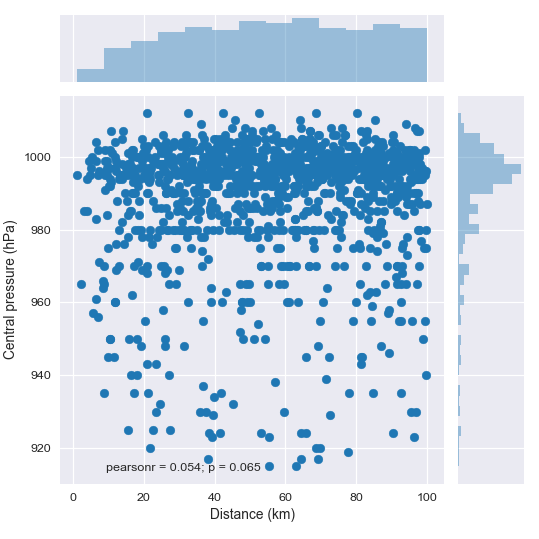

In [4]:
g = sns.jointplot(x='distance', y='pressure', data=min_dist)
g.set_axis_labels("Distance (km)", "Central pressure (hPa)")

We'll save this data to file, possibly useful for later investigation...

In [5]:
min_dist.reset_index(drop=True).to_csv("C:/WorkSpace/data/derived/tc/minimum_distance.csv", sep=",", header=True)
minimum_dist = min_dist.reset_index(drop=True)

Let's link it to the observed maximum daily wind gust data now. The maximum daily wind gust data are stored in individual files per station, so we need to sort through each record and locate the corresponding maximum wind gust, based on the date of occurrence. 

First set up some functions to assist with loading and comparing the data. The first one is a simple date parse function that converts the year, month, day and time values from the observation files into a `datetime` object. 

The second function finds the record (from the observations) with the closest matching datetime value to the record from the list of TC passes.

In [6]:
def parse(yr, month, day, time):
    """
    Parse year, month and day as strings and return a datetime.
    
    Handles the case of a missing time string (Pandas returns nan 
    if the field is empty).
    """
    if time is np.nan:
        time='0000'
    timestr = '{0}-{1}-{2} {3}'.format(yr, month, day, time)
    
    return datetime.strptime(timestr, '%Y-%m-%d %H%M')

In [7]:
def flc(df, dtobj):
    return df.iloc[np.argmin(np.abs(df['datetime'] - dtobj))]

Some constants that will help to handle the results of the matching process...

In [8]:
minimum_dist['gust'] = pd.Series(np.zeros(len(minimum_dist)), index=minimum_dist.index)
obspath = "C:/WorkSpace/data/raw/daily_max_wind_gust/"

OBSNAMES = ['dc', 'Id', 'Year', 'Month', 'Day', 'GustSpeed', 'GustQuality', 'GustDir', 'DirQuality', 'Time', 'TimeQuality', 'N']
CONVERT = {'GustSpeed': lambda s: float(s or 0)}
stnnum = "0000"

outputcols = ['Station', 'Id', 'SerialNum', 'TCName', 'Date', 'Distance', 'Pressure', 'GustSpeed']
outputdf = pd.DataFrame(columns=outputcols)


Now iterate over all the records in the TC passes. We only open the maximum daily wind gust file for each station once (since opening it multiple times would be an unnecessary overhead), and match the datetime from the TC pass to the daily maximum gust observations. 

We then create a temporary `Series` that we use to append to the final `DataFrame` that holds the data. And at teh end of it all, we filter out any records where the gust wind speed value is zero.

In [9]:
for index, row in minimum_dist.iterrows():
    if row['Id'] != stnnum:
        stnnum = row['Id']
        filename = "DC02D_Data_{0:06d}_999999999425050.txt".format(row['Id'])
        filepath = os.path.join(obspath, filename)
        if os.path.exists(filepath):
            df = pd.read_csv(filepath, skipinitialspace=True, skiprows=1, names=OBSNAMES, 
                             parse_dates={'datetime':[2,3,4,9]}, date_parser=parse, 
                             index_col=False, converters=CONVERT)
        else:
            print("No observations for {0}".format(row['Station']))
    else:
        # Data frame already loaded:
        dt = datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')
        matchdf = flc(df, dt)
        s1 = pd.Series(np.array([row['Station'], row['Id'], row['serialnum'], 
                        row['TCname'], dt, row['distance'], row['pressure'], 
                        matchdf['GustSpeed']]), 
                       index=outputcols)
        outputdf = outputdf.append([s1])

# Filter the output data frame to remove any records where the gust speed is zero
outputdf = outputdf[outputdf['GustSpeed'] > 0.]

Now repeat the plot from above...

<IPython.core.display.Javascript object>


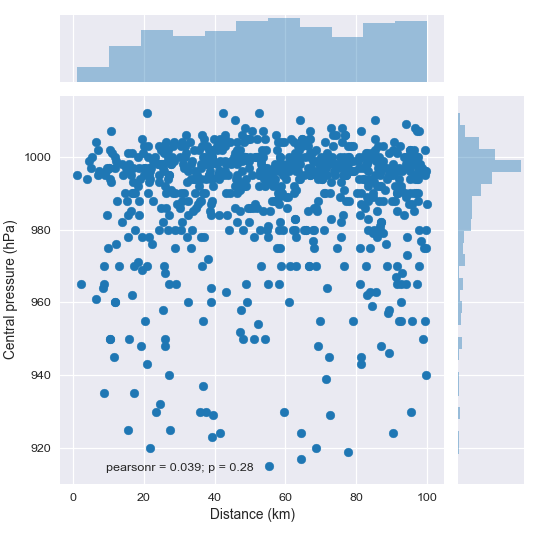

In [10]:
g = sns.jointplot(x='Distance', y='Pressure', data=outputdf)
g.set_axis_labels("Distance (km)", "Central pressure (hPa)")

But now we can add in the information about the maximum wind gusts for each record. When we colour the scatter points by gust wind speed, we can discern a pattern, where the highest wind gusts are associated with lower pressure values and closer passages (the lower left corner). 

<IPython.core.display.Javascript object>


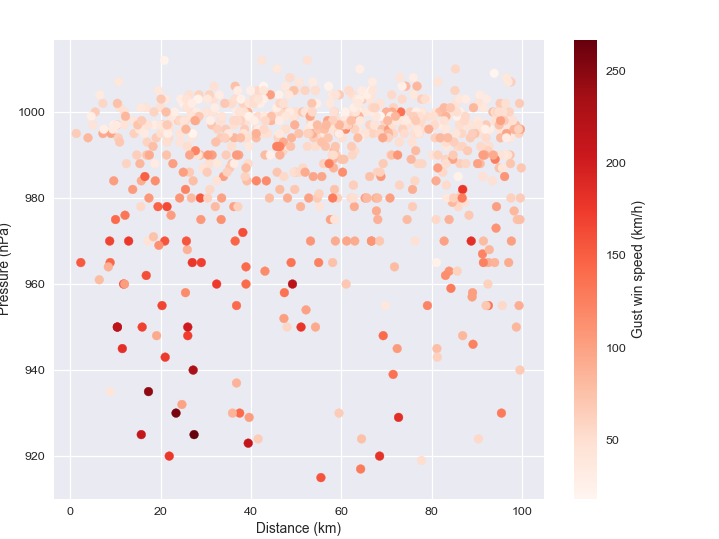

In [11]:
fig, ax = plt.subplots(1, 1)
cm = ax.scatter(outputdf['Distance'], outputdf['Pressure'], c=outputdf['GustSpeed'], cmap='Reds')
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Pressure (hPa)")
plt.colorbar(cm, label='Gust win speed (km/h)')

And for completeness, I include a `PairPlot` of the distance, pressure and gust wind speed for the 763 observations of maximum gust wind speed associated with the passage of a TC within 100 km of the station.

The distribution of distance is fairly uniform (which is not entirely unexpected), but slightly skewed to the right (there's very few that pass within about 10 km of stations). 

Both the pressure and wind speed distributions are narrow and peaked at high (low) values respectively. Again, this should be expected, since the majority of stations are on the mainland, so TCs will have weakened, and the wind speeds reduced due to passage over land. 

I guess we could do some sort of check against distance from the coastline to see how that plays out...

<IPython.core.display.Javascript object>


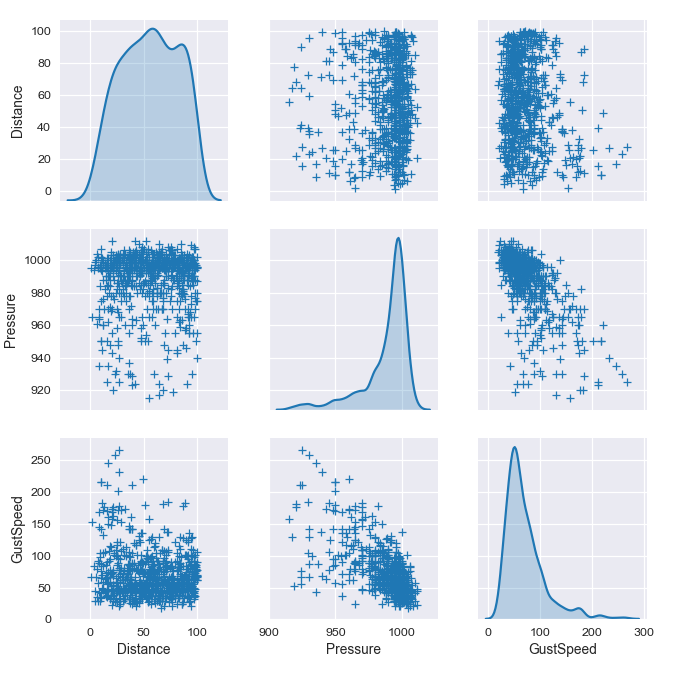

In [12]:
sns.pairplot(outputdf, vars=['Distance','Pressure','GustSpeed'], markers='+',
             plot_kws=dict(s=50, edgecolor="b", linewidth=1),
             diag_kind='kde', diag_kws=dict(shade=True))

In [13]:
filtered = outputdf.groupby(['Station', 'SerialNum'])
filtered_events = filtered.apply(lambda g: g[g['GustSpeed'] == g['GustSpeed'].max()])
filtered_events.reset_index(drop=True).to_csv("C:/WorkSpace/data/derived/tc/tc_obswind_speeds.csv", sep=",", header=True)